In [1]:
# Importação das bibliotecas necessárias
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Configurações opcionais de visualização
plt.style.use("seaborn-v0_8")
pd.set_option("display.max_rows", 10)
pd.set_option("display.width", 120)

# Definições básicas
symbol = "NFLX"
start_date = "2018-01-01"
end_date = "2024-07-20"

# Download dos dados históricos
df = yf.download(symbol, start=start_date, end=end_date)

# Visualização inicial
df.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX
Date,,,,,
2018-01-02,20.107000,20.165001,19.542,19.610001,109669000
2018-01-03,20.504999,20.621000,20.150,20.205000,85914000
2018-01-04,20.563000,20.705000,20.400,20.620001,60296000
2018-01-05,20.999001,21.002001,20.559,20.725000,70332000
2018-01-08,21.205000,21.250000,20.844,21.002001,55802000


Valores ausentes por coluna:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

✅ CSV salvo em: C:\Users\natha\My_space\Data_Science\FIAP\fase_4\notebooks\data\nflx_2018-01-01_2024-07-20.csv


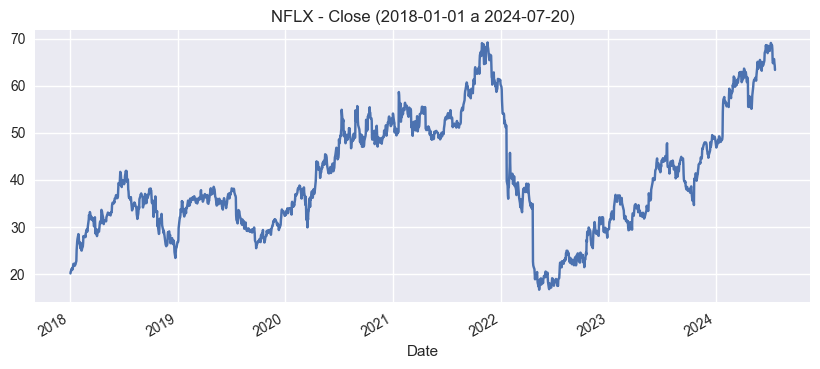

Price,Close,High,Low,Open,Volume
Date,,,,,
2018-01-02,20.107000,20.165001,19.542,19.610001,109669000
2018-01-03,20.504999,20.621000,20.150,20.205000,85914000
2018-01-04,20.563000,20.705000,20.400,20.620001,60296000
2018-01-05,20.999001,21.002001,20.559,20.725000,70332000
2018-01-08,21.205000,21.250000,20.844,21.002001,55802000


In [2]:
from pathlib import Path

# 1) "Achatar" as colunas caso venham em MultiIndex (Price/Ticker)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# 2) Garantir ordem cronológica e nome do índice
df = df.sort_index()
df.index.name = "Date"

# 3) Checar valores ausentes
print("Valores ausentes por coluna:")
print(df.isna().sum())

# 4) (Opcional) preencher NaNs (normalmente não tem, mas garantimos)
df = df.ffill()

# 5) Salvar CSV em /data
Path("data").mkdir(exist_ok=True)
csv_path = Path("data") / "nflx_2018-01-01_2024-07-20.csv"
df.to_csv(csv_path)
print(f"\n✅ CSV salvo em: {csv_path.resolve()}")

# 6) Plot simples do fechamento
df["Close"].plot(title="NFLX - Close (2018-01-01 a 2024-07-20)", figsize=(10,4))
plt.show()

df.head()


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1) Selecionar apenas a coluna Close
close_prices = df[["Close"]].values

# 2) Normalização (0 a 1)
scaler = MinMaxScaler(feature_range=(0, 1))
close_scaled = scaler.fit_transform(close_prices)

# 3) Função para criar janelas temporais
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# 4) Criar sequências
LOOKBACK = 60
X, y = create_sequences(close_scaled, LOOKBACK)

print("Shape X:", X.shape)
print("Shape y:", y.shape)

# 5) Separação treino / teste (80% / 20%)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 6) Ajustar formato para LSTM: (amostras, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test,  (X_test.shape[0],  X_test.shape[1],  1))

print("\nFinal:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


Shape X: (1587, 60)
Shape y: (1587,)

Final:
X_train: (1269, 60, 1)
X_test : (318, 60, 1)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")

model.summary()


C:\Users\natha\AppData\Roaming\Python\Python311\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0305 - val_loss: 0.0023
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0060 - val_loss: 0.0018
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0

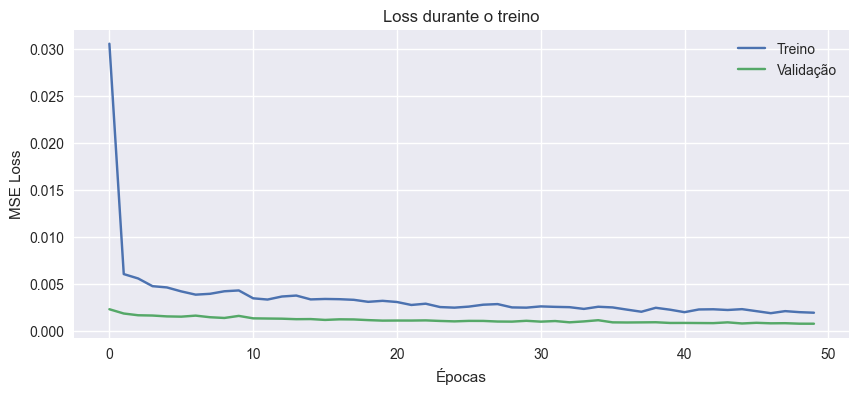

In [6]:
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="Treino")
plt.plot(history.history["val_loss"], label="Validação")
plt.title("Loss durante o treino")
plt.xlabel("Épocas")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) Prever no conjunto de teste (saída vem normalizada 0-1)
y_pred_scaled = model.predict(X_test)

# 2) Voltar para escala original (R$ / US$) - usa o scaler do Close
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
y_pred_real = scaler.inverse_transform(y_pred_scaled).reshape(-1)

# 3) Métricas
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

# MAPE: cuidado com divisão por zero (não deve ocorrer em preço, mas garantimos)
eps = 1e-8
mape = np.mean(np.abs((y_test_real - y_pred_real) / (y_test_real + eps))) * 100

print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
MAE : 1.0613
RMSE: 1.4646
MAPE: 2.20%


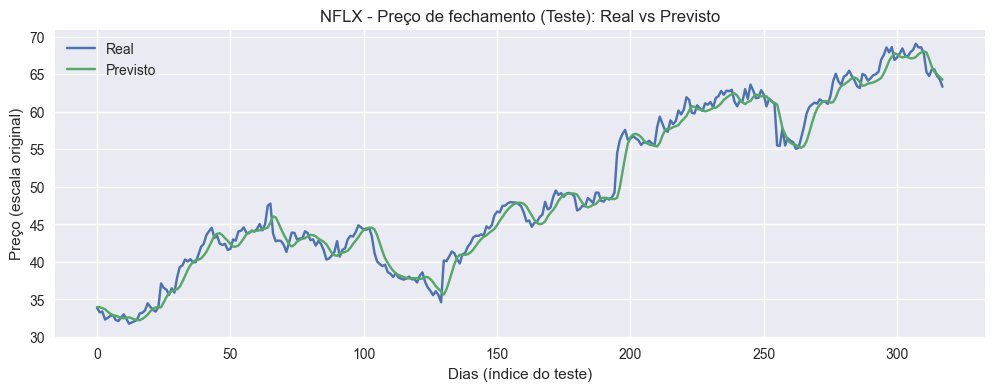

In [8]:
plt.figure(figsize=(12,4))
plt.plot(y_test_real, label="Real")
plt.plot(y_pred_real, label="Previsto")
plt.title("NFLX - Preço de fechamento (Teste): Real vs Previsto")
plt.xlabel("Dias (índice do teste)")
plt.ylabel("Preço (escala original)")
plt.legend()
plt.show()


In [9]:
import joblib
from pathlib import Path

Path("models").mkdir(exist_ok=True)

# Salvar modelo (formato Keras)
model.save("models/lstm_nflx.keras")

# Salvar scaler (necessário para a API desnormalizar / normalizar)
joblib.dump(scaler, "models/scaler_close.pkl")

print("✅ Modelo salvo em: models/lstm_nflx.keras")
print("✅ Scaler salvo em: models/scaler_close.pkl")


✅ Modelo salvo em: models/lstm_nflx.keras
✅ Scaler salvo em: models/scaler_close.pkl
